In [1]:
%matplotlib inline
from ipywidgets import interact, SelectionSlider, IntSlider, FloatSlider
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import scipy.signal

from IPython.display import YouTubeVideo, HTML, Audio
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
t = np.arange(-5, 5, step=0.0001)
s = lambda t, sigma=0.5 : np.exp(-0.5*t**2/sigma**2)

Fs = Slider(start=0.2, end=5, value=1, step=.01, title="Frecuencia de muestreo")

t_dirac = np.arange(-5, 5, step=1/Fs.value)
create_figure = lambda title : Figure(plot_width=300, plot_height=280, title=title, 
                                      toolbar_location="below", x_range=(-5, 5))
p1 = create_figure('Señal Gaussiana')
p2 = create_figure('Peineta de Dirac')
p3 = create_figure('Señal muestreada')
p1.line(t, s(t), line_width=3)
for p in [p1, p2, p3]:
    p.xaxis[0].axis_label = 'Tiempo [s]'
source = ColumnDataSource(data=dict(t=t_dirac, 
                                    tops=np.ones_like(t_dirac),
                                    sd=s(t_dirac)
                                   ))

p2.vbar(x='t', top='tops', source=source, width=0.05)
p3.scatter('t', 'sd', source=source)


callback = CustomJS(args=dict(source=source, Fs=Fs), code="""
    var t_dirac = [];
    var tops = [];
    var sd = []
    for (let i = -5.0; i <= 5.0; i+=1/Fs.value) {
        t_dirac.push(i);
        tops.push(1);
        sd.push(Math.exp(-0.5*Math.pow(i, 2)/Math.pow(0.5, 2)));
    }
    source.data['t'] = t_dirac;
    source.data['tops'] = tops;
    source.data['sd'] = sd;    
    source.change.emit();
""")


Fs.js_on_change('value', callback)
show(column(Fs, row(p1, p2, p3)))

In [3]:
%%capture
fig, ax = plt.subplots(2, figsize=(7, 4), sharex=True, tight_layout=True)
t = np.arange(-4, 4, step=1e-4)

def my_signal(t, a=0, T=0.5):
    s = np.zeros_like(t)
    s[np.absolute(t-a)<T] = 1
    return s

# 2 segundos de espacio entre los dientes de la peinte
def peineta(t):
    s = np.zeros_like(t)
    s[::20000] = 1 
    return s
    
conv_s = np.convolve(my_signal(t), peineta(t), mode='same')

def update(a = 0): 
    ax[0].cla(); ax[1].cla()
    p1, p2 = my_signal(t, 0.1*a - 4), peineta(t)
    ax[0].plot(t, p1, label='señal'); 
    ax[0].plot(t, p2, label='peineta'); 
    ax[0].legend()
    ax[1].plot(t, conv_s); 
    ax[1].set_xlabel('Tiempo [s]'); 
    ax[1].scatter(0.1*a -4, np.sum(p1*p2), s=100, c='k')
    return ()
    
anim = animation.FuncAnimation(fig, update, frames=80, interval=100, blit=True)

In [4]:
HTML(anim.to_html5_video())

In [5]:
x = np.arange(-5, 5, step=0.001)
sigma = Slider(start=0.1, end=2, value=1/np.sqrt(2*np.pi), step=.01, title="sigma")

source = ColumnDataSource(data=dict(x=x, 
                                    gt=np.exp(-0.5*x**2/sigma.value**2),
                                    gf=np.exp(-2*(np.pi*x*sigma.value)**2)*np.sqrt(2*np.pi)*sigma.value
                                   ))

create_figure = lambda title : Figure(plot_width=350, plot_height=280, title=title, 
                                      toolbar_location="below", x_range=(-5, 5))
p1 = create_figure('Dominio de tiempo', )
p2 = create_figure('Dominio de frecuencia')
p1.line('x', 'gt', source=source, line_width=3)
p2.line('x', 'gf', source=source, line_width=3)

callback = CustomJS(args=dict(source=source, sigma=sigma), code="""
    var x = source.data['x'];
    var gt = source.data['gt'];
    var gf = source.data['gf']
    for (var i = 0; i < x.length; i++) {
        gt[i] = Math.exp(-0.5*Math.pow(x[i]/sigma.value, 2));
        gf[i] = Math.sqrt(Math.PI*2)*Math.exp(-2*Math.pow(Math.PI*x[i]*sigma.value, 2))*sigma.value;
        
    }
    source.change.emit();
""")


sigma.js_on_change('value', callback)
show(column(sigma, row(p1, p2)))

In [6]:
def gaussiana(f, sigma):
    return np.sqrt(2*np.pi*sigma**2)*np.exp(-2*(np.pi*f*sigma)**2)

def espectro_discreto(f, sigma):
    S = np.zeros_like(f)
    for m in range(-20, 20):
        S += gaussiana(f - Fs*m, sigma)
    return S

def ventana(f, Fs):
    SW = np.zeros_like(f)
    SW[np.absolute(f) < Fs/2] = 1
    return SW

Fs = 2.
sigma = 1.
f = np.arange(-3*Fs, 3*Fs, step=1e-3)

In [7]:
p1 = Figure(plot_width=600, plot_height=280, toolbar_location="below")
p1.line(f, gaussiana(f, sigma),  color='green', alpha=0.75,
        line_width=3, legend_label='Espectro original')
p1.line(f, espectro_discreto(f, sigma), line_width=3, alpha=0.75,
        legend_label='Espectro discreto')
p1.line(f, ventana(f, Fs), line_width=3, alpha=0.75, color='black',
        line_dash='dashed', legend_label='Ventana cuadrada')

p1.xaxis[0].axis_label = 'Frecuencia [Hz]'
show(p1)

In [8]:
Fs = 2.
sigma = 0.4
f = np.arange(-3*Fs, 3*Fs, step=1e-3)

In [9]:
p1 = Figure(plot_width=600, plot_height=280, toolbar_location="below")
p1.line(f, gaussiana(f, sigma),  color='green', alpha=0.75,
        line_width=3, legend_label='Espectro original')
p1.line(f, espectro_discreto(f, sigma), line_width=3, alpha=0.75,
        legend_label='Espectro discreto')
p1.line(f, ventana(f, Fs), line_width=3, alpha=0.75, color='black',
        line_dash='dashed', legend_label='Ventana cuadrada')

p1.xaxis[0].axis_label = 'Frecuencia [Hz]'
show(p1)

In [10]:
Fs = 0.75
sigma = 1.
f = np.arange(-3*Fs, 3*Fs, step=1e-3)

In [11]:
p1 = Figure(plot_width=600, plot_height=280, toolbar_location="below")
p1.line(f, gaussiana(f, sigma),  color='green', alpha=0.75,
        line_width=3, legend_label='Espectro original')
p1.line(f, espectro_discreto(f, sigma), line_width=3, alpha=0.75,
        legend_label='Espectro discreto')
p1.line(f, ventana(f, Fs), line_width=3, alpha=0.75, color='black',
        line_dash='dashed', legend_label='Ventana cuadrada')

p1.xaxis[0].axis_label = 'Frecuencia [Hz]'
show(p1)

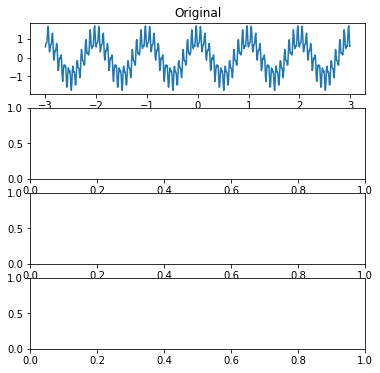

interactive(children=(SelectionSlider(description='Fs', index=5, options=(5, 10, 25, 33, 50, 100), value=100),…

In [12]:
import scipy.fft as fftpack

fig, ax = plt.subplots(4, figsize=(6, 6));
t = np.arange(-3, 3, step=0.01); N = len(t)
s =  np.cos(2*np.pi*t) - 0.5*np.sin(2.0*np.pi*12*t + np.pi/3) + 0.25*np.sin(2.0*np.pi*23*t) 
ax[0].plot(t, s, '-'); ax[0].set_title('Original')

def update(Fs):    
    t_short = t[::int(100/Fs)]; s_short = s[::int(100/Fs)]
    ax[1].cla(); ax[1].plot(t_short, s_short, '.'); ax[1].set_title('Sampled at %0.2f' %(Fs))
    S = fftpack.fft(s_short); f = fftpack.fftshift(fftpack.fftfreq(n=len(S), d=1.0/Fs)); 
    ax[2].cla(); ax[2].plot(f, fftpack.fftshift((np.absolute(S))), linewidth=2);
    S_pad = np.concatenate((S[:int(len(S)/2)], np.zeros(shape=(N-len(S))), S[int(len(S)/2):]))
    ax[2].set_title('Spectrum '); s_recon = np.real(fftpack.ifft(S_pad))
    ax[3].cla(); ax[3].plot(t, s_recon*len(t)/len(t_short), '-', linewidth=2); 
    ax[3].set_title("Reconstruction from padded spectrum");
interact(update, Fs=SelectionSlider(options=[5, 10, 25, 33, 50, 100], value=100));

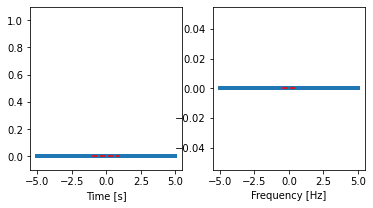

interactive(children=(SelectionSlider(description='T', index=3, options=(0.125, 0.25, 0.5, 1, 2, 4), value=1),…

In [13]:
plt.close('all'); fig, ax = plt.subplots(1, 2, figsize=(6, 3))
t = np.linspace(-5, 5, num=500); f = np.linspace(-5, 5, num=500)
ax[0].set_xlabel('Time [s]'); ax[1].set_xlabel('Frequency [Hz]');
line_square = ax[0].plot(t, np.zeros_like(t), linewidth=4); ax[0].set_ylim([-.1, 1.1])
line_gabor1 = ax[0].plot([-1, 1], [0, 0], 'r--')
line_sinc = ax[1].plot(f, np.zeros_like(f), linewidth=4)
line_gabor2 = ax[1].plot([-0.5, 0.5], [0, 0], 'r--')

def update(T):    
    s = np.zeros_like(t); s[(t> - T) & (t<  T)] = 1    
    line_square[0].set_ydata(s);  line_gabor1[0].set_xdata([-T, T])
    S = 2*T*np.sinc(2*f*T); line_sinc[0].set_ydata(S); 
    line_gabor2[0].set_xdata([-0.5/T, 0.5/T])
    ax[1].set_ylim([-2*T/np.pi, 2.2*T])
    
interact(update, T=SelectionSlider(options=[1/8, 1/4, 1/2, 1, 2, 4], value=1));

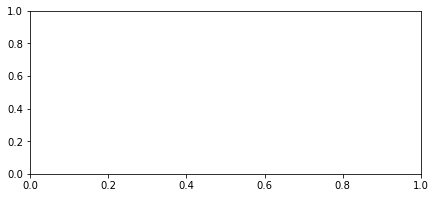

interactive(children=(SelectionSlider(description='dt', options=(0.5, 1.0, 2.0), value=0.5), Output()), _dom_c…

In [14]:
from matplotlib import patches

plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
t = np.arange(-4, 4, step=1e-2)
def update(dt):
    ax.cla(); ax.plot(t, np.cos(2.0*np.pi*t))
    ax.plot(t, np.cos(2.0*np.pi*(1.0+0.125/dt)*t))
    rect = patches.Rectangle((-dt, -1), 2*dt, 2, fill=False, lw=2)
    ax.add_patch(rect)
interact(update, dt=SelectionSlider(options=[0.5, 1., 2.]));

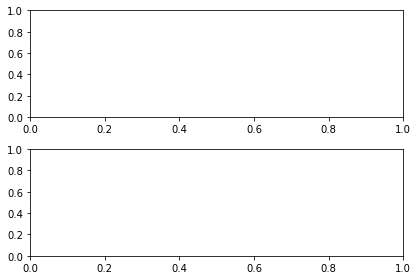

interactive(children=(SelectionSlider(description='T', index=4, options=(0.5, 1, 2, 4, 8, 16), value=8), Selec…

In [15]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(6, 4), tight_layout=True)
f = np.linspace(-3, 3, num=500)
def update(T, window):
    t = np.arange(-T, T, step=1e-2); 
    tf = np.cos(2.0*np.pi*t[:, np.newaxis]*f[:, np.newaxis].T);
    if window == "rect":
        w = np.ones_like(t)
    elif window == "gaussian":
        w = np.exp(-0.5*t**2/(0.333*T)**2)
    s = w*np.cos(2.0*np.pi*t); 
    S = np.average(s[:, np.newaxis]*tf, axis=0)
    ax[0].cla(); ax[1].cla(); ax[0].set_title(r'$s_T(t) = rect(t/T)cos(2\pi t)$')
    ax[0].plot(t, s); ax[1].plot(f, S); ax[1].set_title(r'$\Re[S_T(f)]$')
interact(update, T=SelectionSlider(options=[0.5, 1, 2, 4, 8, 16], value=8),
         window=SelectionSlider(options=["rect", "gaussian"]));

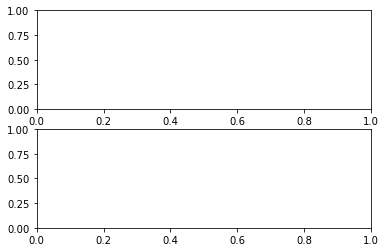

interactive(children=(SelectionSlider(description='f0', options=(0.05, 0.05214178, 0.055414684, 0.2, 0.241245)…

In [16]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(6, 4))
def update(f0, window, log_scale=False):
    n = np.arange(0, 100);
    if window == "rect":
        w = np.ones_like(n)    
    elif window == "hamming":
        w = 0.5 - 0.5*np.cos(2*np.pi*n/(len(n)))
    s = w*np.cos(2.0*np.pi*f0*n); f = fftpack.fftshift(fftpack.fftfreq(n=len(s), d=1))
    S = fftpack.fftshift(np.absolute(fftpack.fft(s)))
    ax[0].cla(); ax[1].cla(); ax[0].set_title(r'$w[n]cos(2\pi f_0 n)$')
    ax[0].plot(n, s); ax[1].plot(f, S); ax[1].set_title(r'$|S_T(f)|$')
    if log_scale:
        ax[1].set_yscale('log')
interact(update, f0=SelectionSlider(options=[0.05, 0.05214178, 0.055414684, 0.2, 0.241245], value=0.05),
         window=SelectionSlider(options=["rect", "hamming"]));

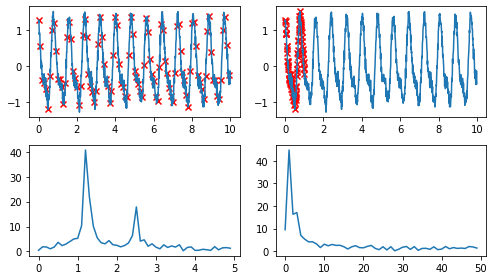

In [17]:
f0=1.234
t_plot = np.linspace(0, 10, 1000)

x_plot = np.cos(2.0*np.pi*f0*t_plot) + 0.4*np.cos(2.0*np.pi*2*f0*t_plot +np.pi/4) + 0.1*np.random.randn(1000)

t, x = t_plot[::10], x_plot[::10]
X = fftpack.fft(x)[:len(x)//2]
freq = fftpack.fftfreq(n=len(x), d=t[1]-t[0])[:len(x)//2]

fig, ax = plt.subplots(2, 2, figsize=(7, 4), tight_layout=True)
ax[0, 0].plot(t_plot,x_plot)
ax[0, 0].scatter(t, x, marker='x', c='r')
ax[1, 0].plot(freq, np.absolute(X))

t, x = t_plot[:100], x_plot[:100]
X = fftpack.fft(x)[:len(x)//2]
freq = fftpack.fftfreq(n=len(x), d=t[1]-t[0])[:len(x)//2]
ax[0, 1].plot(t_plot,x_plot)
ax[0, 1].scatter(t, x, marker='x', c='r')
ax[1, 1].plot(freq, np.absolute(X));

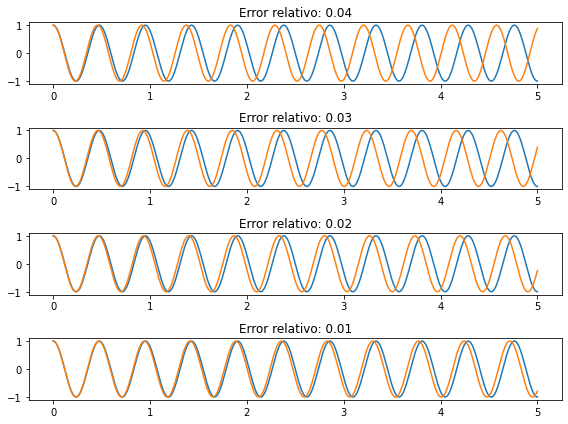

In [18]:
t, dt = np.linspace(0.0, 5.0, num=1000, retstep=True)

fig, ax = plt.subplots(4, figsize=(8, 6), tight_layout=True)

for k in range(4):
    ax[3-k].plot(t, np.cos(2.0*np.pi*2.1*t))
    ax[3-k].plot(t, np.cos(2.0*np.pi*2.1*(1+0.01+0.01*k)*t))
    ax[3-k].set_title('Error relativo: %0.2f' %(0.01+0.01*k))